In [1]:
ls

catboost_info/   Hackathon_dataset.ipynb  __pycache__/
Data_Train.xlsx  modelaccuracyscores      Sample_submission.xlsx
Final_Pred.xlsx  paramsearch.py           Test_set.xlsx


In [39]:
import pandas as pd
import seaborn as sns
import numpy as np
df_train = pd.read_excel("Data_Train.xlsx")
df_to_predict = pd.read_excel("Test_set.xlsx")

In [40]:
print("Number of rows in training dataset",df_train.shape)
print("Number of rows in prediction dataset",df_to_predict.shape)

Number of rows in training dataset (10683, 11)
Number of rows in prediction dataset (2671, 10)


In [41]:
df_train.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


### Removing null values

In [42]:
#Check for null values in the dataset
df_train.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [43]:
#Check null column values
null_columns=df_train.columns[df_train.isnull().any()]
print(df_train[df_train.isnull().any(axis=1)][null_columns].head())

     Route Total_Stops
9039   NaN         NaN


In [44]:
#drop null column values
df_train.dropna(inplace=True)

In [45]:
# Select duplicate rows except first occurrence based on all columns
duplicateRowsDF = df_train[df_train.duplicated()]
print("Total Duplicate Rows except first occurrence based on all columns are :")
duplicateRowsDF.shape

Total Duplicate Rows except first occurrence based on all columns are :


(220, 11)

In [46]:
#remove duplicate rows in training dataset
df_train.drop_duplicates(keep='first',inplace=True)

In [47]:
#See values in columns of dataset 
df_to_predict.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1 stop,No info
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL → BOM → COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL → BOM → COK,08:00,21:00,13h,1 stop,No info
4,Air Asia,24/06/2019,Banglore,Delhi,BLR → DEL,23:55,02:45 25 Jun,2h 50m,non-stop,No info


In [48]:
df_train.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


## Data cleaning

In [49]:
print("Train set:\n",df_train["Additional_Info"].value_counts())
print("\nPrediction set:\n",df_to_predict["Additional_Info"].value_counts())

Train set:
 No info                         8182
In-flight meal not included     1926
No check-in baggage included     318
1 Long layover                    19
Change airports                    7
Business class                     4
No Info                            3
1 Short layover                    1
2 Long layover                     1
Red-eye flight                     1
Name: Additional_Info, dtype: int64

Prediction set:
 No info                         2148
In-flight meal not included      444
No check-in baggage included      76
Business class                     1
1 Long layover                     1
Change airports                    1
Name: Additional_Info, dtype: int64


In [50]:
# replace repeating value in train set
df_train["Additional_Info"] = df_train["Additional_Info"].replace({'No Info': 'No info'})

In [51]:
df_to_predict["Additional_Info"].value_counts()

No info                         2148
In-flight meal not included      444
No check-in baggage included      76
Business class                     1
1 Long layover                     1
Change airports                    1
Name: Additional_Info, dtype: int64

In [52]:
df_to_predict["Destination"].value_counts()

Cochin       1145
Banglore      710
Delhi         317
New Delhi     238
Hyderabad     186
Kolkata        75
Name: Destination, dtype: int64

In [53]:
df_train["Destination"] = df_train["Destination"].replace({'New Delhi': 'Delhi'})
df_to_predict["Destination"] = df_to_predict["Destination"].replace({'New Delhi': 'Delhi'})

In [54]:
# Assign values manually to Total_stops column since label encoder might assign 
# wrong values. Like it can assign value 1 to 'non-stop' or 2 to '3 stops' 
df_train.Total_Stops.replace(['1 stop', 'non-stop', '2 stops', '3 stops', '4 stops'], [1, 0, 2, 3, 4], inplace=True)
df_to_predict.Total_Stops.replace(['1 stop', 'non-stop', '2 stops', '3 stops', '4 stops'], [1, 0, 2, 3, 4], inplace=True)
df_train["Total_Stops"] = df_train["Total_Stops"].astype(int)
df_to_predict["Total_Stops"] = df_to_predict["Total_Stops"].astype(int)

In [55]:
df_train["Total_Stops"].dtype

dtype('int32')

In [56]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10462 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10462 non-null  object
 1   Date_of_Journey  10462 non-null  object
 2   Source           10462 non-null  object
 3   Destination      10462 non-null  object
 4   Route            10462 non-null  object
 5   Dep_Time         10462 non-null  object
 6   Arrival_Time     10462 non-null  object
 7   Duration         10462 non-null  object
 8   Total_Stops      10462 non-null  int32 
 9   Additional_Info  10462 non-null  object
 10  Price            10462 non-null  int64 
dtypes: int32(1), int64(1), object(9)
memory usage: 939.9+ KB


In [57]:
df_to_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2671 entries, 0 to 2670
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          2671 non-null   object
 1   Date_of_Journey  2671 non-null   object
 2   Source           2671 non-null   object
 3   Destination      2671 non-null   object
 4   Route            2671 non-null   object
 5   Dep_Time         2671 non-null   object
 6   Arrival_Time     2671 non-null   object
 7   Duration         2671 non-null   object
 8   Total_Stops      2671 non-null   int32 
 9   Additional_Info  2671 non-null   object
dtypes: int32(1), object(9)
memory usage: 198.4+ KB


### Feature Engineering

In [58]:
# feature engineering on Date_of_Journey column
# Extract day and month of journey from the above column in both train and test dataset

df_train["isWeekend"] = ((pd.to_datetime(df_train["Date_of_Journey"], format = '%d/%m/%Y').dt.dayofweek) // 5 == 1).astype(int)
df_train["Day_of_Week"] = pd.to_datetime(df_train["Date_of_Journey"], format = '%d/%m/%Y').dt.day_name()
df_train["Day_Of_Journey"] = pd.to_datetime(df_train["Date_of_Journey"], format = '%d/%m/%Y').dt.day.astype(float)
df_train["Month_of_Journey"] = pd.to_datetime(df_train["Date_of_Journey"], format = '%d/%m/%Y').dt.month.astype(float)

df_to_predict["isWeekend"] = ((pd.to_datetime(df_to_predict["Date_of_Journey"], format = '%d/%m/%Y').dt.dayofweek) // 5 == 1).astype(int)
df_to_predict["Day_Of_Journey"] = pd.to_datetime(df_to_predict["Date_of_Journey"], format = '%d/%m/%Y').dt.day.astype(float)
df_to_predict["Day_of_Week"] = pd.to_datetime(df_to_predict["Date_of_Journey"], format = '%d/%m/%Y').dt.day_name()
df_to_predict["Month_of_Journey"] = pd.to_datetime(df_to_predict["Date_of_Journey"], format = '%d/%m/%Y').dt.month.astype(float)


In [59]:
# Drop original feature from train and test dataset 
df_train.drop(labels = 'Date_of_Journey', axis = 1, inplace = True)
df_to_predict.drop(labels = 'Date_of_Journey', axis = 1, inplace = True)

In [60]:
# cleaning duration column in train dataset
duration = list(df_train["Duration"])

for i in range(len(duration)) :
    if len(duration[i].split()) != 2:
        if 'h' in duration[i] :
            duration[i] = duration[i].strip() + ' 0m'
        elif 'm' in duration[i] :
            duration[i] = '0h {}'.format(duration[i].strip())

dur_hours = []
dur_minutes = []  
dur_seconds = []
for i in range(len(duration)) :
    dur_minutes.append(int(duration[i].split()[0][:-1])*60 + int(duration[i].split()[1][:-1]))
    dur_seconds.append(int(duration[i].split()[0][:-1])*60*60 + int(duration[i].split()[1][:-1])*60)
df_train["Duration_minutes"] = dur_minutes
df_train.drop(["Duration"], axis=1, inplace = True)

In [61]:
type(df_train["Duration_minutes"][1])

numpy.int64

In [62]:
# cleaning duration column in dataset to predict
duration = list(df_to_predict["Duration"])

for i in range(len(duration)) :
    if len(duration[i].split()) != 2:
        if 'h' in duration[i] :
            duration[i] = duration[i].strip() + ' 0m'
        elif 'm' in duration[i] :
            duration[i] = '0h {}'.format(duration[i].strip())

dur_hours = []
dur_minutes = []  
dur_seconds = []
for i in range(len(duration)) :
    dur_minutes.append(int(duration[i].split()[0][:-1])*60 + int(duration[i].split()[1][:-1]))
    dur_seconds.append(int(duration[i].split()[0][:-1])*60*60 + int(duration[i].split()[1][:-1])*60)
df_to_predict["Duration_minutes"] = dur_minutes
df_to_predict.drop(labels = 'Duration', axis = 1, inplace = True)

In [63]:
#Cleaning Departure and Arrival Times
# Training Set
df_train['Depart_Time_Hour'] = pd.to_datetime(df_train.Dep_Time).dt.hour
df_train['Depart_Time_Minutes'] = pd.to_datetime(df_train.Dep_Time).dt.minute
df_train.drop(labels = 'Dep_Time', axis = 1, inplace = True)
df_train['Arr_Time_Hour'] = pd.to_datetime(df_train.Arrival_Time).dt.hour
df_train['Arr_Time_Minutes'] = pd.to_datetime(df_train.Arrival_Time).dt.minute
df_train.drop(labels = 'Arrival_Time', axis = 1, inplace = True)

# Prediction Set
df_to_predict['Depart_Time_Hour'] = pd.to_datetime(df_to_predict.Dep_Time).dt.hour
df_to_predict['Depart_Time_Minutes'] = pd.to_datetime(df_to_predict.Dep_Time).dt.minute
df_to_predict.drop(labels = 'Dep_Time', axis = 1, inplace = True)
df_to_predict['Arr_Time_Hour'] = pd.to_datetime(df_to_predict.Arrival_Time).dt.hour
df_to_predict['Arr_Time_Minutes'] = pd.to_datetime(df_to_predict.Arrival_Time).dt.minute
df_to_predict.drop(labels = 'Arrival_Time', axis = 1, inplace = True)

In [65]:
type(df_train["Depart_Time_Hour"][1])

numpy.int64

In [69]:
df_train['Depart_Time_Hour'] = df_train['Depart_Time_Hour'].astype(float)
df_to_predict['Depart_Time_Hour'] = df_to_predict['Depart_Time_Hour'].astype(float)
df_train['Arr_Time_Hour'] = df_train['Arr_Time_Hour'].astype(float)
df_to_predict['Arr_Time_Hour'] = df_to_predict['Arr_Time_Hour'].astype(float)

df_train['Depart_Time_Minutes'] = df_train['Depart_Time_Minutes'].astype(float)
df_to_predict['Depart_Time_Minutes'] = df_to_predict['Depart_Time_Minutes'].astype(float)
df_train['Arr_Time_Minutes'] = df_train['Arr_Time_Minutes'].astype(float)
df_to_predict['Arr_Time_Minutes'] = df_to_predict['Arr_Time_Minutes'].astype(float)

In [70]:
type(df_train["Depart_Time_Hour"][1])

numpy.float64

In [71]:
df_train['Depart_Time_Hour'] = df_to_predict['Depart_Time_Hour'] + df_to_predict['Depart_Time_Minutes']/60
df_to_predict['Depart_Time_Hour'] = df_to_predict['Depart_Time_Hour'] + df_to_predict['Depart_Time_Minutes']/60

In [72]:
df_train.drop(["Depart_Time_Minutes"], axis=1, inplace = True)
df_to_predict.drop(["Depart_Time_Minutes"], axis=1, inplace = True)

In [73]:
df_train['Arr_Time_Hour'] = df_to_predict['Arr_Time_Hour'] + df_to_predict['Arr_Time_Minutes']/60
df_to_predict['Arr_Time_Hour'] = df_to_predict['Arr_Time_Hour'] + df_to_predict['Arr_Time_Minutes']/60

In [74]:
df_train.drop(["Arr_Time_Minutes"], axis=1, inplace = True)
df_to_predict.drop(["Arr_Time_Minutes"], axis=1, inplace = True)

In [124]:
bins = [-1, 3, 6, 9, 12, 15, 18, 21, 24]
labels = ['late evening','magical hours','early morning','morning','early afternoon','afternoon','early evening','evening']
df_train['part_of_day'] = pd.cut(df_train['Depart_Time_Hour'], bins=bins, labels=labels)
df_to_predict['part_of_day'] = pd.cut(df_to_predict['Depart_Time_Hour'], bins=bins, labels=labels)

df_train['part_of_day'] = df_train['part_of_day'].astype('string')
df_to_predict['part_of_day'] = df_to_predict['part_of_day'].astype('string')

In [130]:
df_train['part_of_day'].value_counts()

early morning      555
morning            485
early evening      430
afternoon          382
early afternoon    261
evening            247
magical hours      244
late evening        52
Name: part_of_day, dtype: Int64

In [131]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10462 entries, 0 to 10682
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Airline           10462 non-null  object 
 1   Source            10462 non-null  object 
 2   Destination       10462 non-null  object 
 3   Route             10462 non-null  object 
 4   Total_Stops       10462 non-null  int32  
 5   Additional_Info   10462 non-null  object 
 6   Price             10462 non-null  int64  
 7   isWeekend         10462 non-null  int32  
 8   Day_of_Week       10462 non-null  object 
 9   Day_Of_Journey    10462 non-null  float64
 10  Month_of_Journey  10462 non-null  float64
 11  Duration_minutes  10462 non-null  int64  
 12  Depart_Time_Hour  2656 non-null   float64
 13  Arr_Time_Hour     2656 non-null   float64
 14  part_of_day       2656 non-null   string 
dtypes: float64(4), int32(2), int64(2), object(6), string(1)
memory usage: 1.5+ MB


In [132]:
# We created X and y columns for training dataset while y column for dataset to predict will
# be generated by our model in final step
X = df_train.drop(["Price"], axis=1)
y = np.log1p(df_train["Price"])
# y = df_train["Price"]
X_to_predict = df_to_predict

In [133]:
X.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,isWeekend,Day_of_Week,Day_Of_Journey,Month_of_Journey,Duration_minutes,Depart_Time_Hour,Arr_Time_Hour,part_of_day
0,IndiGo,Banglore,Delhi,BLR → DEL,0,No info,1,Sunday,24.0,3.0,170,17.500000,4.416667,afternoon
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2,No info,0,Wednesday,1.0,5.0,445,6.333333,10.333333,early morning
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2,No info,1,Sunday,9.0,6.0,1140,19.250000,19.000000,early evening
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1,No info,1,Sunday,12.0,5.0,325,8.000000,21.000000,early morning
4,IndiGo,Banglore,Delhi,BLR → NAG → DEL,1,No info,0,Friday,1.0,3.0,285,23.916667,2.750000,evening


In [134]:
#Separate categorical and numerical columns in dataframe
X_categorical = X.select_dtypes(exclude=['number', 'float'])
X_numerical = X.select_dtypes(include=['number', 'float',])

X_to_predict_categorical = X_to_predict.select_dtypes(exclude=['number', 'float'])
X_to_predict_numerical = X_to_predict.select_dtypes(include=['number', 'float'])

In [135]:
# Check if categorical columns are assigned properly
X_categorical.head()

#Create a back up copy specifically for plotting graphs
X_numerical_graph = X_numerical.copy()
X_categorical_graph = X_categorical.copy()

In [136]:
#Check if numerical columns are assigned properly
X_categorical.shape

(10462, 7)

In [137]:
X_numerical.head()

,Total_Stops,isWeekend,Day_Of_Journey,Month_of_Journey,Duration_minutes,Depart_Time_Hour,Arr_Time_Hour
0,0,1,24.0,3.0,170,17.500000,4.416667
1,2,0,1.0,5.0,445,6.333333,10.333333
2,2,1,9.0,6.0,1140,19.250000,19.000000
3,1,1,12.0,5.0,325,8.000000,21.000000
4,1,0,1.0,3.0,285,23.916667,2.750000


In [138]:
#We replace values based on insights gathered from graphs generated in further steps
X_categorical["Airline"].replace(to_replace={'Multiple carriers Premium economy':'Other', 
                                                        'Jet Airways Business':'Other',
                                                        'Vistara Premium economy':'Other',
                                                        'Trujet':'Other'
                                                   },    
                                        inplace=True)

X_to_predict_categorical["Airline"].replace(to_replace={'Multiple carriers Premium economy':'Other', 
                                                        'Jet Airways Business':'Other',
                                                        'Vistara Premium economy':'Other',
                                                        'Trujet':'Other'
                                                   },    
                                        inplace=True)

C:\Users\kesha\Anaconda3\lib\site-packages\pandas\core\series.py:4569: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [139]:
#We replace values based on insights gathered from graphs generated in further steps
X_categorical["Additional_Info"].replace(to_replace={'Change airports':'Other', 
                                                        'Business class':'Other',
                                                        '1 Short layover':'Other',
                                                        'Red-eye flight':'Other',
                                                        '2 Long layover':'Other',   
                                                   },    
                                        inplace=True)
X_to_predict_categorical["Additional_Info"].replace(to_replace={'Change airports':'Other', 
                                                        'Business class':'Other',
                                                        '1 Short layover':'Other',
                                                        'Red-eye flight':'Other',
                                                        '2 Long layover':'Other',   
                                                   },    
                                        inplace=True)

In [117]:
X_categorical.head()

,Airline,Source,Destination,Route,Additional_Info,Day_of_Week,part_of_day
0,IndiGo,Banglore,Delhi,BLR → DEL,No info,Sunday,afternoon
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,No info,Wednesday,early morning
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,No info,Sunday,early evening
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,No info,Sunday,early morning
4,IndiGo,Banglore,Delhi,BLR → NAG → DEL,No info,Friday,evening


In [102]:
X_categorical["Additional_Info"].value_counts()

No info                         8185
In-flight meal not included     1926
No check-in baggage included     318
1 Long layover                    19
Other                             14
Name: Additional_Info, dtype: int64

In [87]:
X_categorical.head()

,Airline,Source,Destination,Route,Additional_Info,Day_of_Week,part_of_day
0,IndiGo,Banglore,Delhi,BLR → DEL,No info,Sunday,afternoon
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,No info,Wednesday,early morning
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,No info,Sunday,early evening
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,No info,Sunday,early morning
4,IndiGo,Banglore,Delhi,BLR → NAG → DEL,No info,Friday,evening


In [89]:
X_to_predict_categorical.head()

,Airline,Source,Destination,Route,Additional_Info,Day_of_Week,part_of_day
0,Jet Airways,Delhi,Cochin,DEL → BOM → COK,No info,Thursday,afternoon
1,IndiGo,Kolkata,Banglore,CCU → MAA → BLR,No info,Sunday,early morning
2,Jet Airways,Delhi,Cochin,DEL → BOM → COK,In-flight meal not included,Tuesday,early evening
3,Multiple carriers,Delhi,Cochin,DEL → BOM → COK,No info,Tuesday,early morning
4,Air Asia,Banglore,Delhi,BLR → DEL,No info,Monday,evening


In [140]:
X_categorical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10462 entries, 0 to 10682
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10462 non-null  object
 1   Source           10462 non-null  object
 2   Destination      10462 non-null  object
 3   Route            10462 non-null  object
 4   Additional_Info  10462 non-null  object
 5   Day_of_Week      10462 non-null  object
 6   part_of_day      2656 non-null   string
dtypes: object(6), string(1)
memory usage: 973.9+ KB


In [141]:
#Label encode and hot encode categorical columns
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
X_categorical = X_categorical.apply(LabelEncoder().fit_transform)
X_to_predict_categorical = X_to_predict_categorical.apply(LabelEncoder().fit_transform)

TypeError: Encoders require their input to be uniformly strings or numbers. Got ['NAType', 'str']

In [157]:
#Check values after label encoding
X_categorical.head()

,Airline,Source,Destination,Route,Additional_Info,Day_of_Week
0,3,0,5,18,3,3
1,1,3,0,84,3,6
2,4,2,1,118,3,3
3,3,3,0,91,3,3
4,3,0,5,29,3,0


In [158]:
#Check values in numerical columns
X_numerical.head()

,Total_Stops,isWeekend,Day_Of_Journey,Month_of_Journey,Duration_minutes,Depart_Time_Hour,Depart_Time_Minutes,Arr_Time_Hour,Arr_Time_Minutes
0,0,1,24.0,3.0,170,22,20,1,10
1,2,0,1.0,5.0,445,5,50,13,15
2,2,1,9.0,6.0,1140,9,25,4,25
3,1,1,12.0,5.0,325,18,5,23,30
4,1,0,1.0,3.0,285,16,50,21,35


In [159]:
X_numerical.head()

,Total_Stops,isWeekend,Day_Of_Journey,Month_of_Journey,Duration_minutes,Depart_Time_Hour,Depart_Time_Minutes,Arr_Time_Hour,Arr_Time_Minutes
0,0,1,24.0,3.0,170,22,20,1,10
1,2,0,1.0,5.0,445,5,50,13,15
2,2,1,9.0,6.0,1140,9,25,4,25
3,1,1,12.0,5.0,325,18,5,23,30
4,1,0,1.0,3.0,285,16,50,21,35


In [160]:
# Check the skew of all numerical features
from scipy.stats import skew
skewed_feats = X_numerical.apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))


Skew in numerical features: 

There are 9 skewed numerical features to Box Cox transform


In [161]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
cols_train = list(X_numerical.columns)
index_train = X_numerical.index.tolist()
cols_test = list(X_to_predict_numerical.columns)
index_test = X_to_predict_numerical.index.tolist()

# We can also use standard scaler if required...The code is commented for now
# Get column names first
X_numerical_names = X_numerical.columns
X_numerical_index = X_numerical.index
X_to_predict_numerical_names = X_to_predict_numerical.columns
# Create the Scaler object
# scaler = StandardScaler()
# Fit your data on the scaler object
# scaled_df = scaler.fit_transform(X_numerical)
# X_numerical = pd.DataFrame(scaled_df, columns=X_numerical_names, index=index_train)
# scaled_df_to_predict = scaler.fit_transform(X_to_predict_numerical)
# X_to_predict_numerical = pd.DataFrame(scaled_df_to_predict, columns=X_to_predict_numerical_names, index = index_test)

# mmx = MinMaxScaler()
# df_minmax = mmx.fit_transform(X_numerical)
# df_minmax_test = mmx.fit_transform(X_to_predict_numerical)
# X_numerical = pd.DataFrame(data=df_minmax,columns=cols_train,index=index_train)
# X_to_predict_numerical = pd.DataFrame(data=df_minmax_test,columns=cols_test,index=index_test)

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.5
for feat in skewed_features:
    #all_data[feat] += 1
    X_numerical[feat] = boxcox1p(X_numerical[feat], lam)
    X_to_predict_numerical[feat] = boxcox1p(X_to_predict_numerical[feat], lam)


C:\Users\kesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\kesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [162]:
#Check values in numerical columns after minmax scaling
X_numerical.head(5)

,Total_Stops,isWeekend,Day_Of_Journey,Month_of_Journey,Duration_minutes,Depart_Time_Hour,Depart_Time_Minutes,Arr_Time_Hour,Arr_Time_Minutes
0,0.000000,0.828427,8.000000,2.000000,24.153394,7.591663,7.165151,0.828427,4.633250
1,1.464102,0.000000,0.828427,2.898979,40.237424,2.898979,12.282857,5.483315,6.000000
2,1.464102,0.828427,4.324555,3.291503,65.557383,4.324555,8.198039,2.472136,8.198039
3,0.828427,0.828427,5.211103,2.898979,34.110940,6.717798,2.898979,7.797959,9.135529
4,0.828427,0.000000,0.828427,2.000000,31.823069,6.246211,12.282857,7.380832,10.000000


In [163]:
#Merge categorical and numerical columns back into respective X and X_to_predict
X = pd.concat([X_categorical, X_numerical], axis=1)
X_to_predict = pd.concat([X_to_predict_categorical, X_to_predict_numerical], axis=1)

In [164]:
#Check shape of all three to verify that merge was done properly in above step
print(X.shape, X_numerical.shape, X_categorical.shape)
print(X_to_predict.shape, X_to_predict_numerical.shape, X_to_predict_categorical.shape)
print(y.shape)

(10462, 15) (10462, 9) (10462, 6)
(2671, 15) (2671, 9) (2671, 6)
(10462,)


In [165]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
import numpy as np
from sklearn.metrics import mean_squared_log_error
# We have created a function to print accuracy metrics which can be used
# to get accuracy metrics of all models in upcoming steps
def print_accuracy_report(y_test, y_pred,X_test, model):
 print('R Squared(Accuracy)', metrics.r2_score(y_test, y_pred))   
 print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
 print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
 print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
 print('Root Mean Squared Log Error',np.sqrt(mean_squared_log_error( y_test, y_pred )))

In [166]:
# we have created a function to generate linear regression model
# which can then be called again after feature selection or other steps
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
def LinearRegressionModel(X,y):
 X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42, test_size=0.3)
 regressor = LinearRegression()  
 regressor.fit(X_train, y_train)
 y_pred = regressor.predict(X_test)
 print(print_accuracy_report(y_test, y_pred, X_test, regressor))
 return regressor
linearModel = LinearRegressionModel(X,y)

R Squared(Accuracy) 0.5829776436980549
Mean Absolute Error: 0.268511771211811
Mean Squared Error: 0.10989290784085518
Root Mean Squared Error: 0.3315009922169995
Root Mean Squared Log Error 0.03325445838385667
None


In [167]:
# we have created a function to generate linear regression model
# which can then be called again after feature selection or other steps
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import accuracy_score
def BayesianRidgeModel(X,y):
 X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42, test_size=0.3)
 regressor = BayesianRidge()  
 regressor.fit(X_train, y_train)
 y_pred = regressor.predict(X_test)
 print(print_accuracy_report(y_test, y_pred, X_test, regressor))
 return regressor
linearModel = BayesianRidgeModel(X,y)

R Squared(Accuracy) 0.5830493836459871
Mean Absolute Error: 0.268469551352667
Mean Squared Error: 0.10987400307144057
Root Mean Squared Error: 0.33147247709491745
Root Mean Squared Log Error 0.03325143163587198
None


In [168]:
#similarly define a function for random forest regressor
from sklearn.ensemble import RandomForestRegressor
def RandomForestRegressorModel(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42, test_size=0.3)
    rf = RandomForestRegressor(random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    print(print_accuracy_report(y_test, y_pred, X_test, rf))
    return rf
randomForestModel = RandomForestRegressorModel(X,y)

R Squared(Accuracy) 0.9328971787976746
Mean Absolute Error: 0.07307034189802832
Mean Squared Error: 0.01768280293565193
Root Mean Squared Error: 0.13297670072479587
Root Mean Squared Log Error 0.013258201182045754
None


In [169]:
# get feature importances from a model
import matplotlib.pyplot as plt
def plotFeatureImportances(model):
    #first print all features importances in descending order
    feature_importances = pd.DataFrame(model.feature_importances_,
                                   index = X.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
    print(feature_importances)
    # Next plot feature importances to get idea about where the curve breaks
    # in the graph i.e. select top appropriate features
    features = X.columns.tolist()
    importances = model.feature_importances_
    indices = np.argsort(importances)
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

                     importance
Duration_minutes       0.604645
Airline                0.101628
Day_Of_Journey         0.048513
Month_of_Journey       0.038857
Additional_Info        0.038237
Total_Stops            0.037220
Route                  0.023563
Arr_Time_Hour          0.017124
Depart_Time_Minutes    0.016901
Destination            0.016464
Day_of_Week            0.015747
Depart_Time_Hour       0.015735
Arr_Time_Minutes       0.014131
Source                 0.005677
isWeekend              0.005558


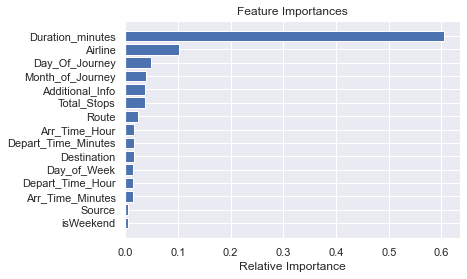

In [170]:
plotFeatureImportances(randomForestModel)

In [171]:
# Since we need to send our final predictions made on test dataset in excel format
# the below function can be used to generate excel file for a given model which can then be submitted
# to the hackathon
def generateFinalPredictionFile(model):
    y_test_pred = model.predict(X_to_predict.values)
    y_test_pred_exp = np.exp(y_test_pred)
    print(y_test_pred_exp)
    pd.DataFrame(y_test_pred_exp, columns = ['Price']).to_excel("Final_Pred.xlsx", index = False)  

In [172]:
# select features using extratreesclassifier
from sklearn.ensemble import ExtraTreesRegressor
def ExtraTreesRegressorModel(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42, test_size=0.3)
    rf = ExtraTreesRegressor()
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    print(print_accuracy_report(y_test, y_pred, X_test, rf))
    return rf
extraTreeRegressorModel = ExtraTreesRegressorModel(X,y)

R Squared(Accuracy) 0.9363036708548086
Mean Absolute Error: 0.06846495237431247
Mean Squared Error: 0.016785130875537776
Root Mean Squared Error: 0.12955744237803468
Root Mean Squared Log Error 0.012919078401531826
None


                     importance
Total_Stops            0.320045
Duration_minutes       0.227341
Airline                0.120432
Day_Of_Journey         0.053170
Route                  0.043050
Month_of_Journey       0.042457
Destination            0.041036
Additional_Info        0.032344
Source                 0.028277
Arr_Time_Hour          0.019473
Depart_Time_Hour       0.017559
Depart_Time_Minutes    0.016942
Day_of_Week            0.015162
Arr_Time_Minutes       0.013204
isWeekend              0.009509


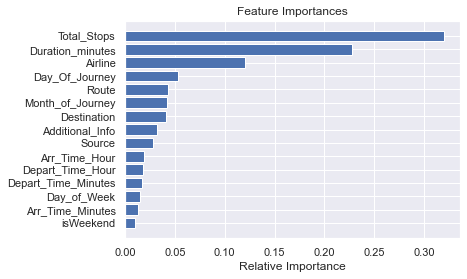

In [173]:
plotFeatureImportances(extraTreeRegressorModel)

In [174]:
# select features using XGboost
from xgboost import XGBRegressor
def XGBRegressorModel(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42, test_size=0.3)
    rf = XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =42, nthread = -1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    print(print_accuracy_report(y_test, y_pred, X_test, rf))
    return rf
xgbRegressorModel = XGBRegressorModel(X,y)

R Squared(Accuracy) 0.9198906053299988
Mean Absolute Error: 0.10317037338339598
Mean Squared Error: 0.021110269491842304
Root Mean Squared Error: 0.1452937352119571
Root Mean Squared Log Error 0.01454969986250799
None


In [175]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
params = {
  'reg_alpha':[1e-5]
}
def XGBoostRegressorModel(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42, test_size=0.3)
    rf=XGBRegressor(learning_rate =0.1, n_estimators=240,
     subsample=0.8, colsample_bytree=0.8,
     scale_pos_weight=1, seed=42, max_depth= 10, min_child_weight=5,gamma=0.0, reg_alpha=1e-5)
    rf_random = GridSearchCV(estimator = rf, param_grid = params, cv = 3, verbose=2, n_jobs = 8)
    rf_random.fit(X_train, y_train)
    print(rf_random.best_params_)
    y_pred = rf_random.best_estimator_.predict(X_test)
    print(print_accuracy_report(y_test, y_pred, X_test, rf_random.best_estimator_))
    return rf_random.best_estimator_
xgBoostModel = XGBoostRegressorModel(X,y)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   3 | elapsed:   24.2s finished


[02:14:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'reg_alpha': 1e-05}
R Squared(Accuracy) 0.9441813795099061
Mean Absolute Error: 0.07123494105321482
Mean Squared Error: 0.014709212646815954
Root Mean Squared Error: 0.12128154289427535
Root Mean Squared Log Error 0.012110369147314386
None


In [176]:
# generateFinalPredictionFile(xgBoostModel)

                     importance
Total_Stops            0.483229
Duration_minutes       0.099103
Airline                0.087663
Destination            0.061262
Additional_Info        0.044863
Source                 0.041464
Month_of_Journey       0.040687
Route                  0.036413
Day_Of_Journey         0.031983
Day_of_Week            0.021195
isWeekend              0.014299
Depart_Time_Hour       0.010241
Arr_Time_Hour          0.010063
Depart_Time_Minutes    0.009215
Arr_Time_Minutes       0.008320


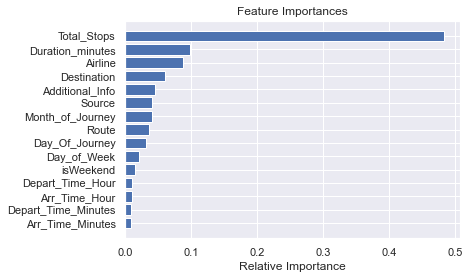

In [177]:
#get feature importances from xgbRegressormodel
plotFeatureImportances(xgbRegressorModel)

In [178]:
from sklearn.ensemble import GradientBoostingRegressor 
def GradientBoostingRegressorModel(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42, test_size=0.3)
    rf = GradientBoostingRegressor()
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    print(print_accuracy_report(y_test, y_pred, X_test, rf))
    return rf
gradientBoostingRegressorModel = XGBRegressorModel(X,y)

R Squared(Accuracy) 0.9198906053299988
Mean Absolute Error: 0.10317037338339598
Mean Squared Error: 0.021110269491842304
Root Mean Squared Error: 0.1452937352119571
Root Mean Squared Log Error 0.01454969986250799
None


In [179]:
# We can either select features manually from the graphs generated above or
# we can use SelectFromModel module to select most appropriate features 
# automatically. 
# Source:- https://towardsdatascience.com/feature-selection-using-random-forest-26d7b747597f
import numpy as np
from sklearn.feature_selection import SelectFromModel
def SelectFeaturesFromModel (model,X):
    sel = SelectFromModel(model, prefit = True)
    selected_feat= X.columns[(sel.get_support())]
    print("Total features selected: ", len(selected_feat))
    print("Names of selected Features:\n", selected_feat)
    print("\n")

In [180]:
print("Top selected from random forest regressor:")
SelectFeaturesFromModel(randomForestModel,X)

print("Top selected from extra trees regressor:")
SelectFeaturesFromModel(extraTreeRegressorModel,X)

print("Top selected from xgboost regressor:")
SelectFeaturesFromModel(xgbRegressorModel,X)

Top selected from random forest regressor:
Total features selected:  2
Names of selected Features:
 Index(['Airline', 'Duration_minutes'], dtype='object')


Top selected from extra trees regressor:
Total features selected:  3
Names of selected Features:
 Index(['Airline', 'Total_Stops', 'Duration_minutes'], dtype='object')


Top selected from xgboost regressor:
Total features selected:  3
Names of selected Features:
 Index(['Airline', 'Total_Stops', 'Duration_minutes'], dtype='object')




In [181]:
from sklearn.svm import SVR
def SVRModel(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42, test_size=0.3)
    regressor=SVR(kernel='linear',degree=1,verbose=True)
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    print(print_accuracy_report(y_test, y_pred, X_test, regressor))
    return regressor
svRegressorModel = SVRModel(X,y)

[LibSVM]R Squared(Accuracy) 0.5770221833374222
Mean Absolute Error: 0.26670173224074917
Mean Squared Error: 0.11146227899487317
Root Mean Squared Error: 0.33385966961415564
Root Mean Squared Log Error 0.03342013792688705
None


In [68]:
pip install param

Note: you may need to restart the kernel to use updated packages.


In [182]:
#Source:- https://effectiveml.com/using-grid-search-to-optimise-catboost-parameters.html
from catboost import CatBoostRegressor
import catboost as cb
from sklearn.model_selection import KFold
# from param import paramsearch
from itertools import product,chain
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
# 'iterations':[250,100,500,1000,2000],
#           'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3], 
#           'l2_leaf_reg':[3,1,5,10,100],
#           'border_count':[32,5,10,20,50,100,200]
params = {'depth':[3,1,2,6,4,5,7,8,9,10],}

def CBRModel(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42, test_size=0.3)
    rf=CatBoostRegressor()
    rf_random = GridSearchCV(estimator = rf, param_grid = params, cv = 3, verbose=2, n_jobs = 8)
    rf_random.fit(X_train, y_train)
    print(rf_random.best_params_)
    y_pred = rf_random.best_estimator_.predict(X_test)
    print(rf_random.best_params_)
    print(print_accuracy_report(y_test, y_pred, X_test, rf_random.best_estimator_))
    return rf_random.best_estimator_
cegbRressorModel = CBRModel(X,y)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  30 out of  30 | elapsed:  2.4min finished


Learning rate set to 0.055631
0:	learn: 0.4975677	total: 432ms	remaining: 7m 11s
1:	learn: 0.4786065	total: 436ms	remaining: 3m 37s
2:	learn: 0.4608477	total: 440ms	remaining: 2m 26s
3:	learn: 0.4429534	total: 444ms	remaining: 1m 50s
4:	learn: 0.4262766	total: 447ms	remaining: 1m 29s
5:	learn: 0.4121936	total: 451ms	remaining: 1m 14s
6:	learn: 0.3991438	total: 456ms	remaining: 1m 4s
7:	learn: 0.3859914	total: 459ms	remaining: 57s
8:	learn: 0.3742865	total: 464ms	remaining: 51.1s
9:	learn: 0.3637877	total: 468ms	remaining: 46.4s
10:	learn: 0.3540496	total: 473ms	remaining: 42.5s
11:	learn: 0.3436457	total: 477ms	remaining: 39.3s
12:	learn: 0.3356200	total: 481ms	remaining: 36.5s
13:	learn: 0.3263024	total: 486ms	remaining: 34.2s
14:	learn: 0.3181300	total: 490ms	remaining: 32.2s
15:	learn: 0.3092098	total: 495ms	remaining: 30.4s
16:	learn: 0.3017028	total: 500ms	remaining: 28.9s
17:	learn: 0.2942581	total: 504ms	remaining: 27.5s
18:	learn: 0.2876461	total: 508ms	remaining: 26.2s
19:	lea

201:	learn: 0.1297410	total: 1.83s	remaining: 7.22s
202:	learn: 0.1296626	total: 1.83s	remaining: 7.2s
203:	learn: 0.1294804	total: 1.84s	remaining: 7.17s
204:	learn: 0.1293494	total: 1.84s	remaining: 7.15s
205:	learn: 0.1291855	total: 1.85s	remaining: 7.13s
206:	learn: 0.1290741	total: 1.86s	remaining: 7.13s
207:	learn: 0.1289110	total: 1.86s	remaining: 7.1s
208:	learn: 0.1286845	total: 1.87s	remaining: 7.08s
209:	learn: 0.1285236	total: 1.88s	remaining: 7.05s
210:	learn: 0.1282986	total: 1.88s	remaining: 7.03s
211:	learn: 0.1281215	total: 1.89s	remaining: 7.01s
212:	learn: 0.1280235	total: 1.89s	remaining: 6.98s
213:	learn: 0.1278185	total: 1.89s	remaining: 6.96s
214:	learn: 0.1276650	total: 1.9s	remaining: 6.94s
215:	learn: 0.1275400	total: 1.9s	remaining: 6.91s
216:	learn: 0.1273466	total: 1.91s	remaining: 6.88s
217:	learn: 0.1271907	total: 1.91s	remaining: 6.86s
218:	learn: 0.1268789	total: 1.92s	remaining: 6.84s
219:	learn: 0.1267766	total: 1.92s	remaining: 6.81s
220:	learn: 0.12

373:	learn: 0.1038405	total: 3.19s	remaining: 5.34s
374:	learn: 0.1037294	total: 3.2s	remaining: 5.33s
375:	learn: 0.1036513	total: 3.21s	remaining: 5.32s
376:	learn: 0.1035443	total: 3.21s	remaining: 5.31s
377:	learn: 0.1034416	total: 3.22s	remaining: 5.3s
378:	learn: 0.1033898	total: 3.23s	remaining: 5.29s
379:	learn: 0.1032924	total: 3.24s	remaining: 5.28s
380:	learn: 0.1031297	total: 3.24s	remaining: 5.27s
381:	learn: 0.1029582	total: 3.25s	remaining: 5.26s
382:	learn: 0.1027953	total: 3.26s	remaining: 5.25s
383:	learn: 0.1027278	total: 3.26s	remaining: 5.24s
384:	learn: 0.1025835	total: 3.27s	remaining: 5.22s
385:	learn: 0.1025424	total: 3.28s	remaining: 5.21s
386:	learn: 0.1024392	total: 3.29s	remaining: 5.21s
387:	learn: 0.1023960	total: 3.3s	remaining: 5.2s
388:	learn: 0.1022852	total: 3.3s	remaining: 5.19s
389:	learn: 0.1021807	total: 3.31s	remaining: 5.18s
390:	learn: 0.1020636	total: 3.33s	remaining: 5.18s
391:	learn: 0.1020069	total: 3.33s	remaining: 5.17s
392:	learn: 0.101

545:	learn: 0.0895340	total: 4.53s	remaining: 3.76s
546:	learn: 0.0894930	total: 4.53s	remaining: 3.75s
547:	learn: 0.0894389	total: 4.54s	remaining: 3.75s
548:	learn: 0.0893610	total: 4.55s	remaining: 3.74s
549:	learn: 0.0892932	total: 4.56s	remaining: 3.73s
550:	learn: 0.0892087	total: 4.56s	remaining: 3.72s
551:	learn: 0.0891732	total: 4.57s	remaining: 3.71s
552:	learn: 0.0891209	total: 4.58s	remaining: 3.7s
553:	learn: 0.0890391	total: 4.58s	remaining: 3.69s
554:	learn: 0.0889724	total: 4.59s	remaining: 3.68s
555:	learn: 0.0889291	total: 4.6s	remaining: 3.67s
556:	learn: 0.0888835	total: 4.61s	remaining: 3.67s
557:	learn: 0.0888575	total: 4.62s	remaining: 3.66s
558:	learn: 0.0887889	total: 4.63s	remaining: 3.65s
559:	learn: 0.0887153	total: 4.63s	remaining: 3.64s
560:	learn: 0.0886172	total: 4.64s	remaining: 3.63s
561:	learn: 0.0885549	total: 4.65s	remaining: 3.62s
562:	learn: 0.0884557	total: 4.66s	remaining: 3.62s
563:	learn: 0.0883944	total: 4.67s	remaining: 3.61s
564:	learn: 0.

708:	learn: 0.0802766	total: 5.71s	remaining: 2.34s
709:	learn: 0.0802100	total: 5.72s	remaining: 2.34s
710:	learn: 0.0801534	total: 5.73s	remaining: 2.33s
711:	learn: 0.0801241	total: 5.73s	remaining: 2.32s
712:	learn: 0.0800723	total: 5.74s	remaining: 2.31s
713:	learn: 0.0800439	total: 5.75s	remaining: 2.3s
714:	learn: 0.0800116	total: 5.76s	remaining: 2.29s
715:	learn: 0.0799258	total: 5.77s	remaining: 2.29s
716:	learn: 0.0798974	total: 5.78s	remaining: 2.28s
717:	learn: 0.0798664	total: 5.78s	remaining: 2.27s
718:	learn: 0.0798345	total: 5.79s	remaining: 2.26s
719:	learn: 0.0797842	total: 5.8s	remaining: 2.25s
720:	learn: 0.0797355	total: 5.8s	remaining: 2.25s
721:	learn: 0.0796492	total: 5.82s	remaining: 2.24s
722:	learn: 0.0795902	total: 5.82s	remaining: 2.23s
723:	learn: 0.0795061	total: 5.83s	remaining: 2.22s
724:	learn: 0.0794739	total: 5.84s	remaining: 2.21s
725:	learn: 0.0794050	total: 5.84s	remaining: 2.21s
726:	learn: 0.0793302	total: 5.85s	remaining: 2.2s
727:	learn: 0.07

888:	learn: 0.0725393	total: 6.93s	remaining: 865ms
889:	learn: 0.0725093	total: 6.94s	remaining: 857ms
890:	learn: 0.0724627	total: 6.94s	remaining: 849ms
891:	learn: 0.0724167	total: 6.95s	remaining: 842ms
892:	learn: 0.0723951	total: 6.96s	remaining: 834ms
893:	learn: 0.0723614	total: 6.97s	remaining: 826ms
894:	learn: 0.0723098	total: 6.97s	remaining: 818ms
895:	learn: 0.0722688	total: 6.98s	remaining: 810ms
896:	learn: 0.0722287	total: 6.99s	remaining: 802ms
897:	learn: 0.0721621	total: 6.99s	remaining: 794ms
898:	learn: 0.0721305	total: 7s	remaining: 786ms
899:	learn: 0.0720808	total: 7s	remaining: 778ms
900:	learn: 0.0720320	total: 7.01s	remaining: 770ms
901:	learn: 0.0719872	total: 7.02s	remaining: 762ms
902:	learn: 0.0719584	total: 7.02s	remaining: 754ms
903:	learn: 0.0719247	total: 7.03s	remaining: 746ms
904:	learn: 0.0718890	total: 7.03s	remaining: 738ms
905:	learn: 0.0718563	total: 7.04s	remaining: 730ms
906:	learn: 0.0717765	total: 7.04s	remaining: 722ms
907:	learn: 0.0717

## Graphs of various features

count    10462.000000
mean      9026.790289
std       4624.849541
min       1759.000000
25%       5224.000000
50%       8266.000000
75%      12344.750000
max      79512.000000
Name: Price, dtype: float64
Skewness: 1.857490
Kurtosis: 13.527896


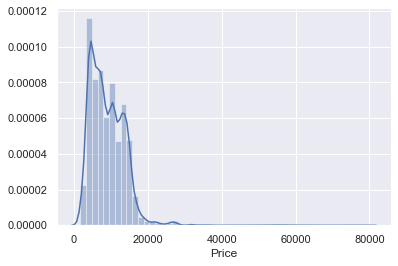

In [183]:
#Source:- https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python
#descriptive statistics summary
import seaborn as sns
print(df_train['Price'].describe())
#skewness and kurtosis
print("Skewness: %f" % df_train['Price'].skew())
print("Kurtosis: %f" % df_train['Price'].kurt())
sns.distplot(df_train['Price'])

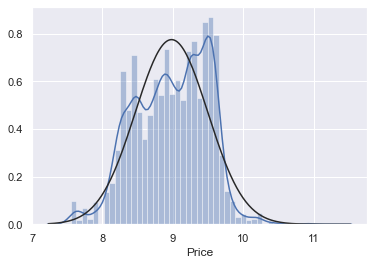

In [184]:
#Check the new distribution 
from scipy.stats import norm, skew 
sns.distplot(np.log1p(df_train["Price"]) , fit=norm);

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


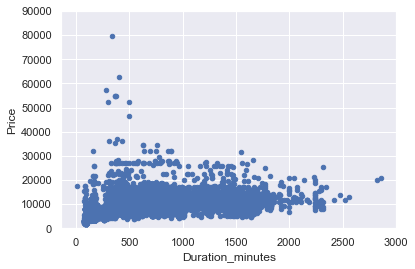

In [185]:
#scatter plot Duration_minutes/Price
var = 'Duration_minutes'
data = pd.concat([df_train['Price'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='Price', ylim=(0,90000));

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


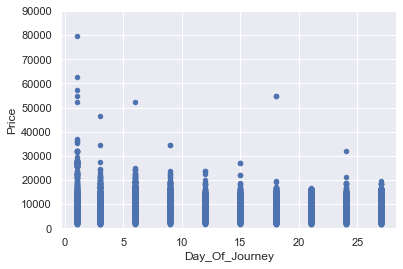

In [186]:
#scatter plot Day_Of_Journey/Price
var = 'Day_Of_Journey'
data = pd.concat([df_train['Price'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='Price', ylim=(0,90000));

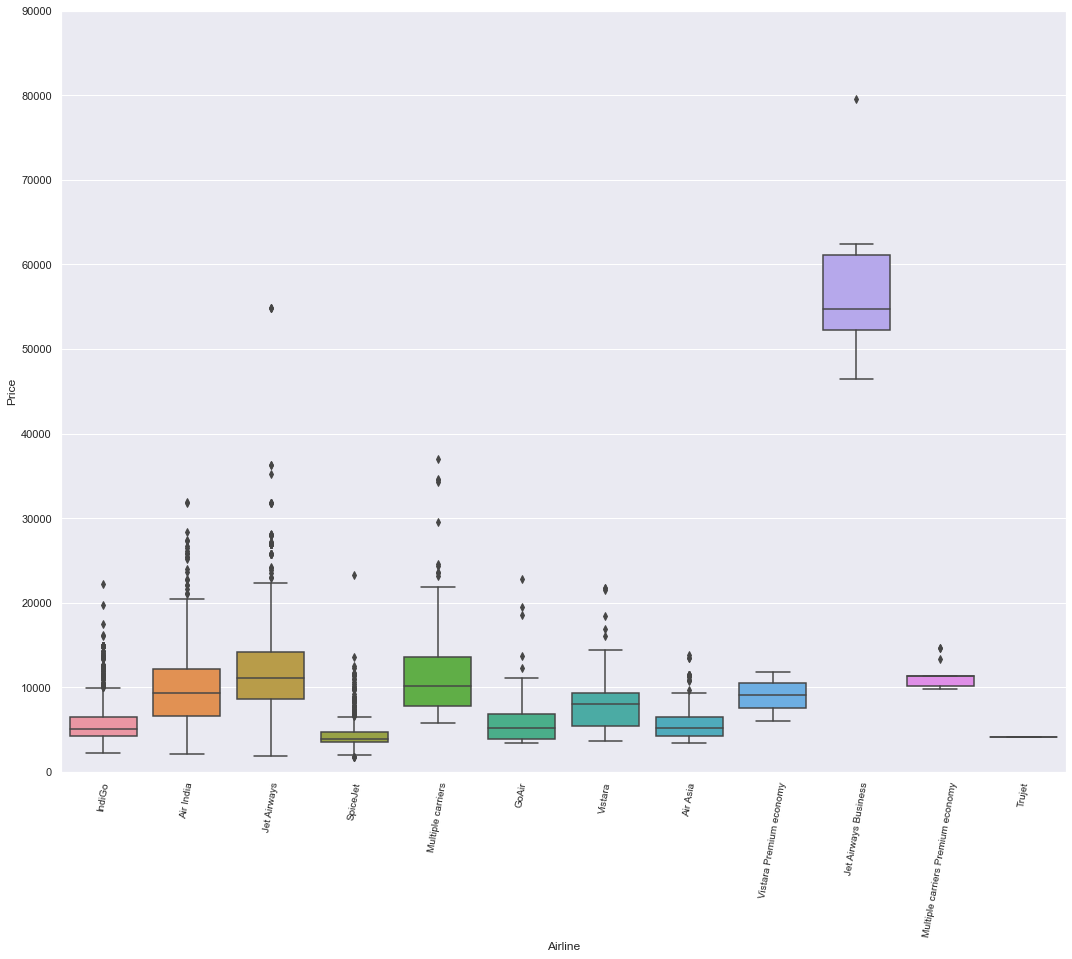

In [187]:
#box plot Airline/Price
var = 'Airline'
data = pd.concat([df_train['Price'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(18, 14))
fig = sns.boxplot(x=var, y="Price", data=data)
plt.xticks(fontsize=10, rotation=80)
fig.axis(ymin=0, ymax=90000);

**Frequency distribution of different airlines in above dataset:-**

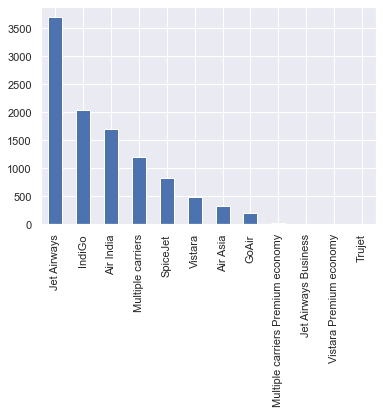

In [188]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
carrier_count = df_train["Airline"].value_counts()
df_train['Airline'].value_counts().plot(kind='bar')

*Insights from above graph:-*  
*Jet airways has highest number of flights i.e. it is preferred flight for travellers*     
*The last four flights can be clubbed into single category of "other flights" for improving accuracy of model*

**Variation of price against total number of stops**:-

Text(0.5, 1.0, 'Total stops')

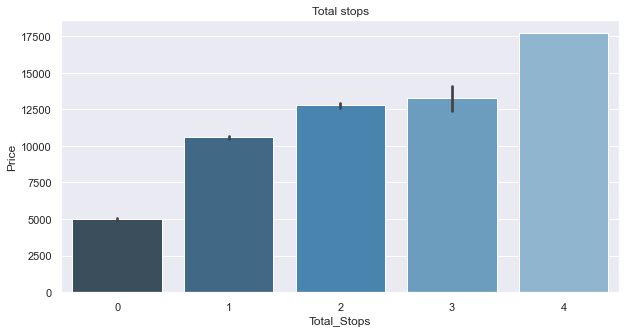

In [189]:
sns.set(style="darkgrid")
figure(figsize=(10,5)) 
sns.barplot(x="Total_Stops", y="Price", data=df_train, palette="Blues_d")
plt.title('Total stops')

*Insight from above graph:-*  
*As expected price of flight tickets is higher for flights with greater number of stops*

**Variation of price with different airline**

(array([    0., 10000., 20000., 30000., 40000., 50000., 60000., 70000.,
        80000.]),
 <a list of 9 Text major ticklabel objects>)

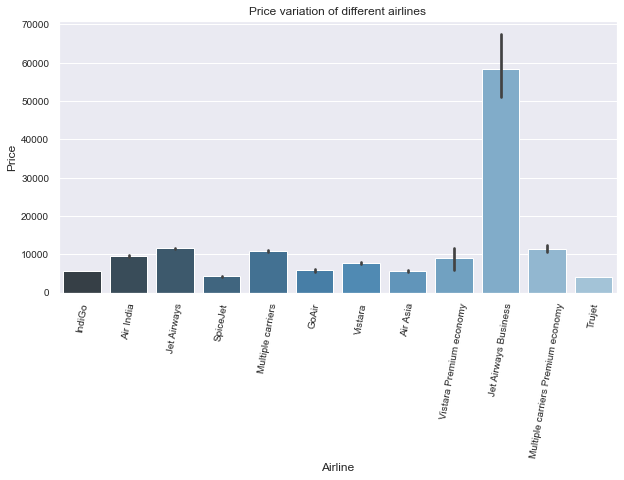

In [190]:
sns.set(style="darkgrid")
figure(figsize=(10,5)) 
sns.barplot(x="Airline", y="Price", data=df_train, palette="Blues_d")
plt.title('Price variation of different airlines')
plt.xticks(fontsize=10, rotation=80)
plt.yticks(fontsize=10)

*Insight:-
Jet airways business ticket is most expensive*

*Insight:-We can combine evening and late eveing into single category for better accuracy*

**Frequency distribution of weekday of airline journey**

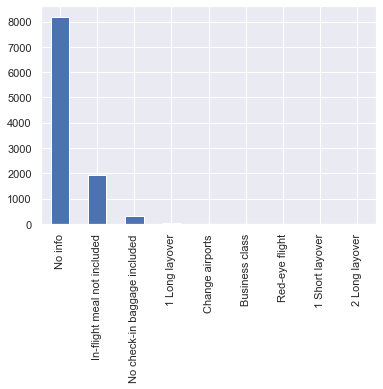

In [191]:
df_train['Additional_Info'].value_counts().plot(kind='bar')

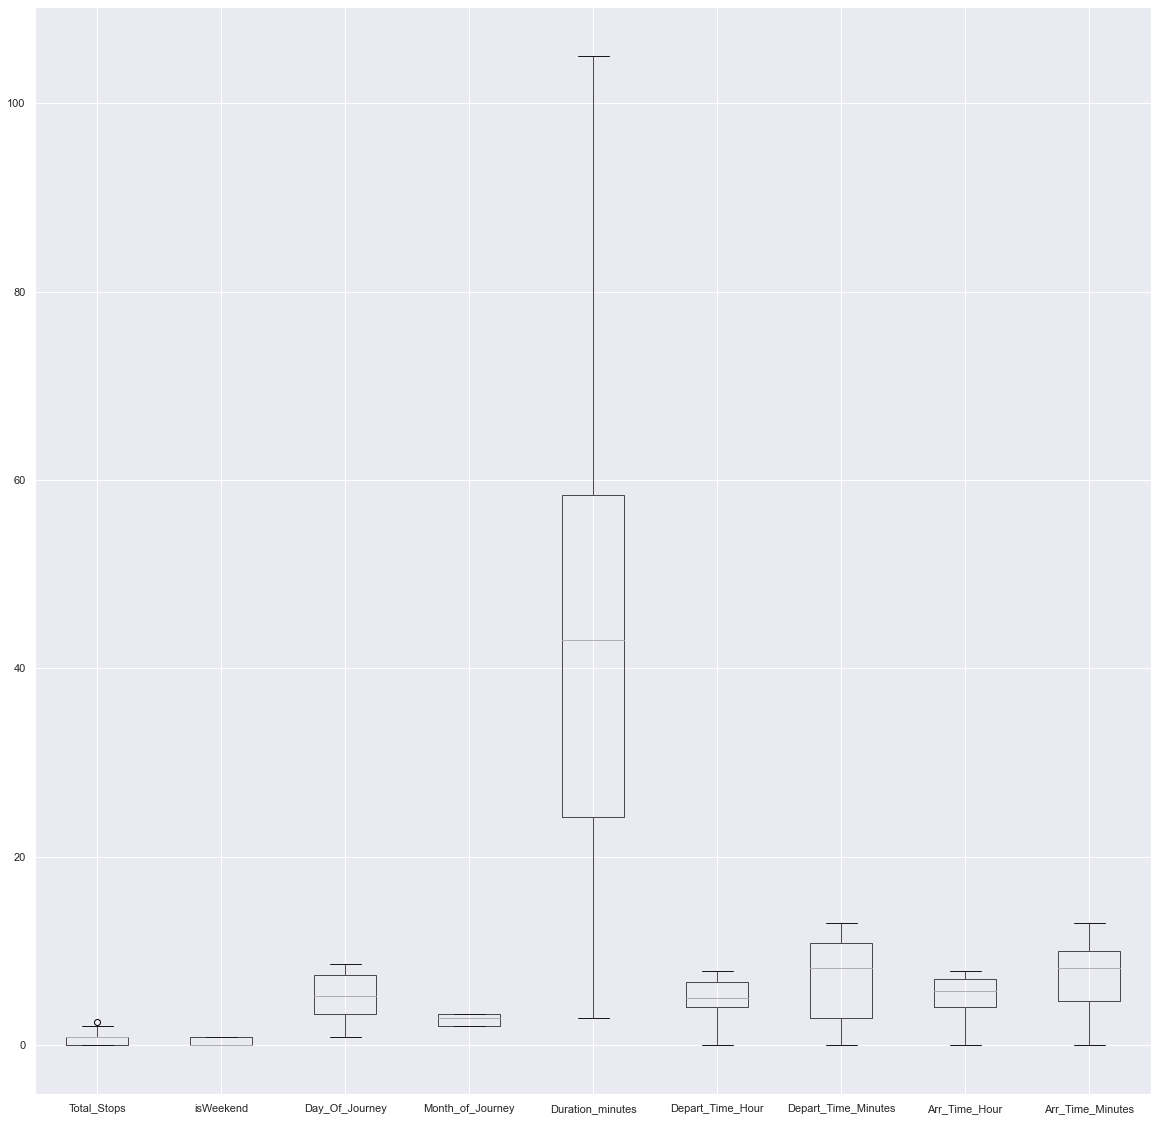

In [192]:
import matplotlib.pyplot as plt
figure(figsize=(20,20)) 
X_numerical.boxplot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A079F11A88>,
      dtype=object)

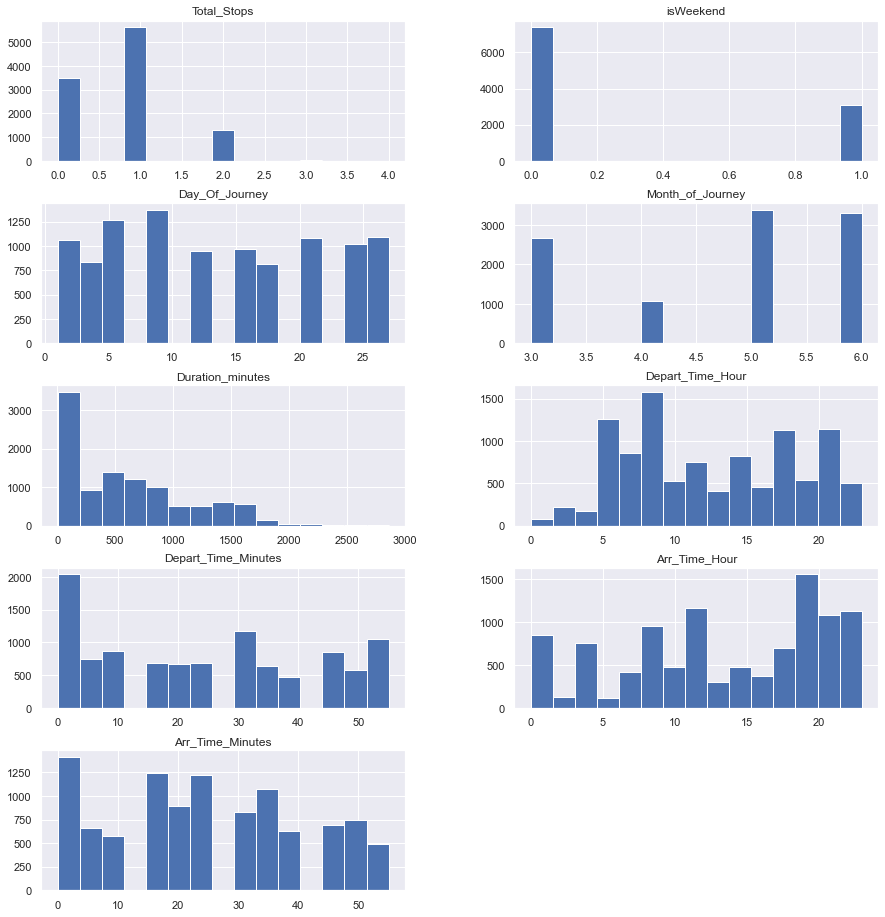

In [193]:
X_numerical_graph.hist(bins=15, figsize=(15, 16), layout=(5, 2))

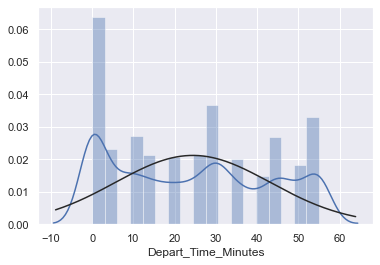

In [194]:
from scipy.stats import norm, skew 
sns.distplot(df_train["Depart_Time_Minutes"] , fit=norm);

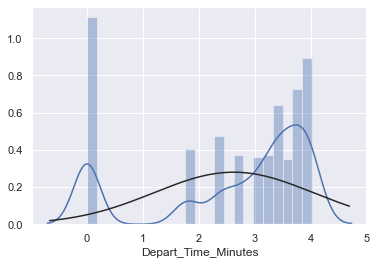

In [195]:
sns.distplot(np.log1p(df_train["Depart_Time_Minutes"]) , fit=norm);

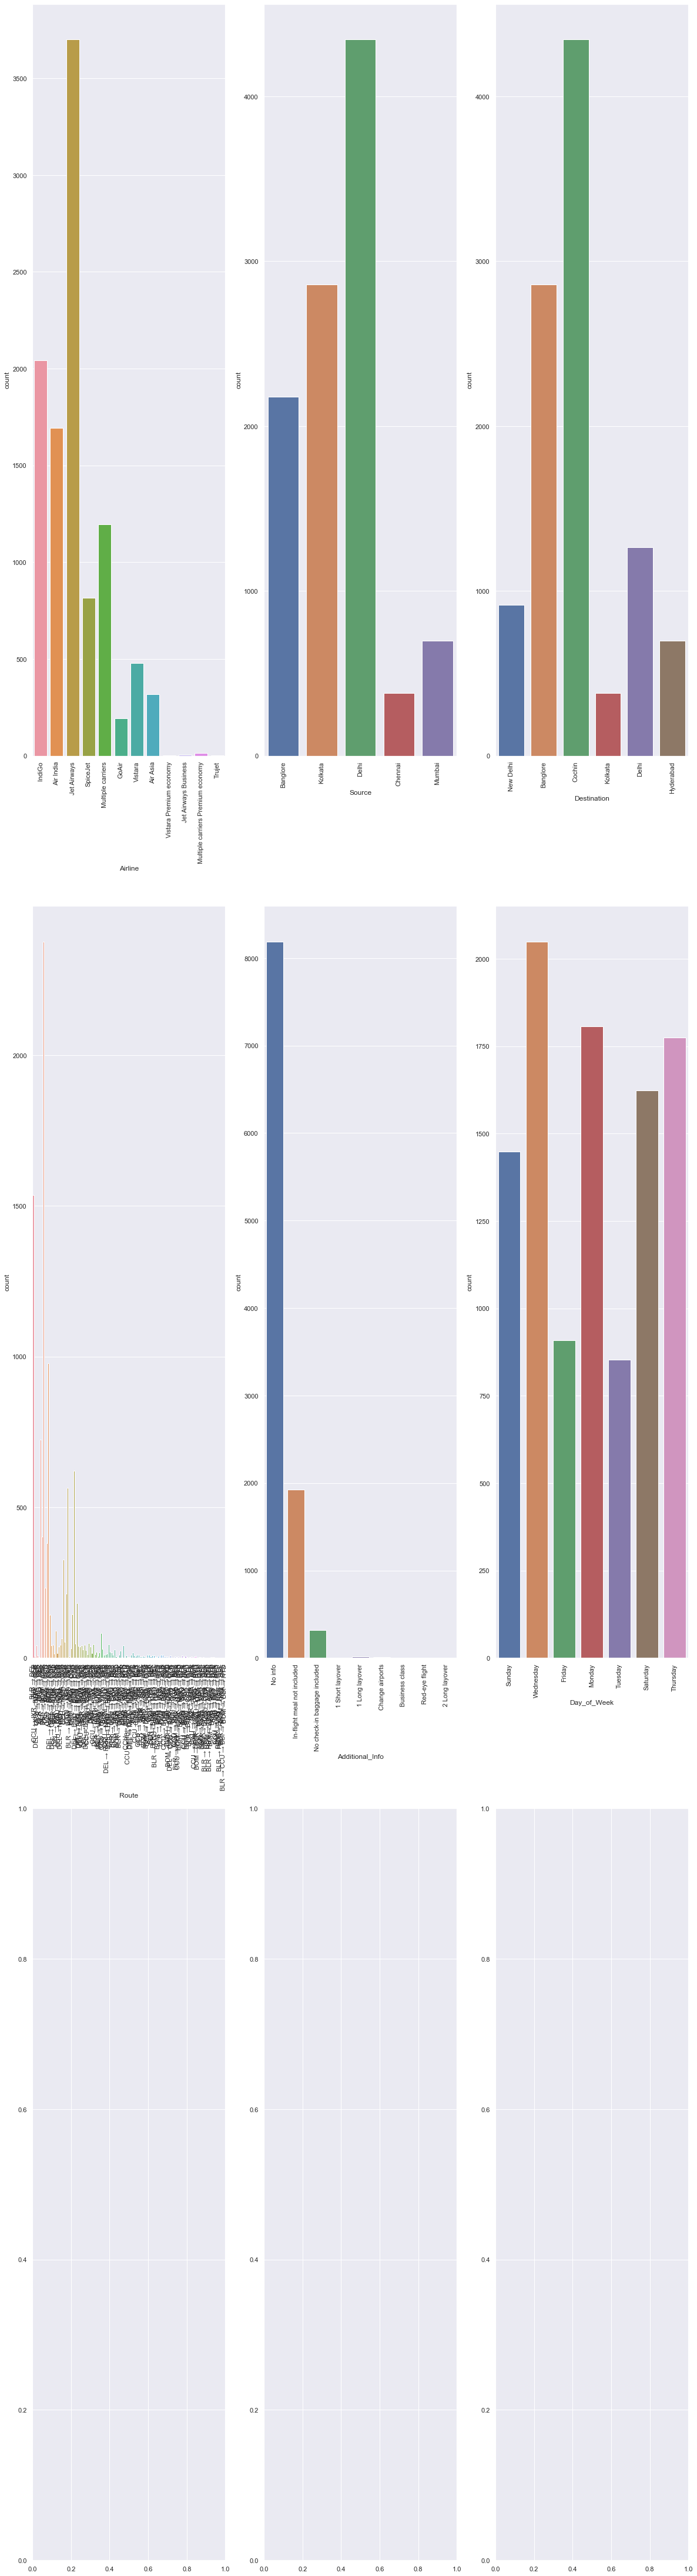

In [196]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(3, 3, figsize=(20, 80))
columns = X_categorical_graph.columns.tolist()
for variable, subplot in zip(columns, ax.flatten()):
    sns.countplot(X_categorical_graph[variable], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

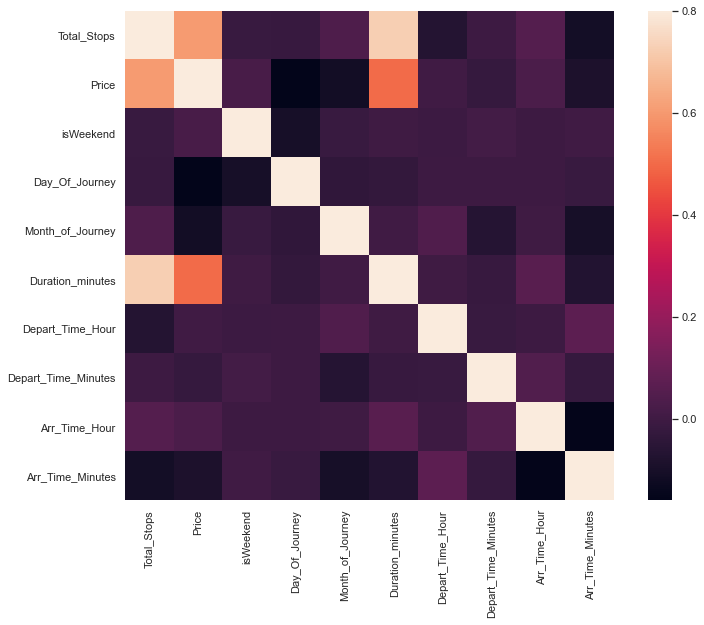

In [197]:
#correlation matrix
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

In [198]:
X_categorical_graph["Additional_Info"].value_counts()

No info                         8185
In-flight meal not included     1926
No check-in baggage included     318
1 Long layover                    19
Change airports                    7
Business class                     4
Red-eye flight                     1
1 Short layover                    1
2 Long layover                     1
Name: Additional_Info, dtype: int64

In [199]:
X_categorical_graph["Airline"].replace(to_replace={'Multiple carriers Premium economy':'Other', 
                                                        'Jet Airways Business':'Other',
                                                        'Vistara Premium economy':'Other',
                                                        'Trujet':'Other'
                                                   },    
                                        inplace=True)
#We have done same step back in the notebook above before label encoding to improve accuracy

In [200]:
X_categorical_graph["Additional_Info"].replace(to_replace={'Change airports':'Other', 
                                                        'Business class':'Other',
                                                        '1 Short layover':'Other',
                                                        'Red-eye flight':'Other',
                                                        '2 Long layover':'Other',   
                                                   },    
                                        inplace=True)
#We have done same step back in the notebook above before label encoding to improve accuracy

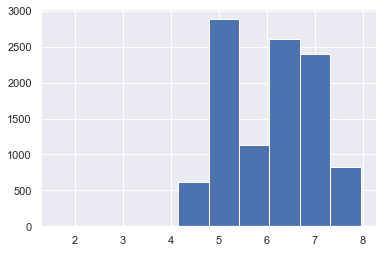

In [201]:
X_numerical_graph["Duration_minutes"].apply(np.log).hist()
#We have done same step back in the notebook above before scaling numrical values to improve accuracy

After improving accuracy using EDA let do hyperparameter tuning to improve model accuracy

## Final Regression Models Optimization using GridSearchCV, RandomizedSearchCV and stacking

In [202]:
# Source:- https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/
import matplotlib.pylab as plt
import numpy as np 
from sklearn.model_selection import ShuffleSplit, train_test_split 
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.model_selection import GridSearchCV 
def GridSearchCVGradientBoostingRegressor(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X.values, y.values,random_state=42, test_size=0.3)
    estimator = GradientBoostingRegressor(random_state=42,n_estimators=800,learning_rate=0.05,max_depth=8)
    cv = ShuffleSplit(n_splits=5, random_state=42, test_size=0.3)
    param_grid={ 
                'subsample':[1.0]
               } 
    n_jobs=8
    regressor = GridSearchCV(estimator=estimator, cv=cv, param_grid=param_grid, n_jobs=n_jobs)
    regressor.fit(X_train, y_train)
    y_pred = regressor.best_estimator_.predict(X_test)
    print(regressor.best_params_)
    print(print_accuracy_report(y_test, y_pred, X_test, regressor.best_estimator_))
    return regressor.best_estimator_
gradientBoostingModelCV = GridSearchCVGradientBoostingRegressor(X,y)

{'subsample': 1.0}
R Squared(Accuracy) 0.9414416896240966
Mean Absolute Error: 0.07164322295186479
Mean Squared Error: 0.015431170315473395
Root Mean Squared Error: 0.12422226175478128
Root Mean Squared Log Error 0.01238456519545141
None


In [203]:
import matplotlib.pylab as plt
import numpy as np 
from sklearn.decomposition import PCA 
from sklearn.model_selection import ShuffleSplit, train_test_split 
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import GridSearchCV 
def GridSearchCVRandomForestRegressor(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42, test_size=0.3)
    estimator = RandomForestRegressor()
    cv = ShuffleSplit(n_splits=5, random_state=42, test_size=0.3)
    estimator = RandomForestRegressor()
    # Create the random grid
    param_grid = { 
    'n_estimators': [10, 18, 22, 200, 700],
    'max_features': ['auto', 'sqrt', 'log2']
    }
    n_jobs=4
    regressor = GridSearchCV(estimator=estimator, cv=cv, param_grid=param_grid, n_jobs=n_jobs)
    regressor.fit(X_train, y_train)
    y_pred = regressor.best_estimator_.predict(X_test)
    print(regressor.best_params_)
    print(print_accuracy_report(y_test, y_pred, X_test, regressor.best_estimator_))
    return regressor.best_estimator_
randomForestRegressorModel = GridSearchCVRandomForestRegressor(X,y)

{'max_features': 'auto', 'n_estimators': 700}
R Squared(Accuracy) 0.9334601344816568
Mean Absolute Error: 0.07267137838641279
Mean Squared Error: 0.01753445396547456
Root Mean Squared Error: 0.13241772526921974
Root Mean Squared Log Error 0.013200633164560844
None


In [204]:
# Source: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ShuffleSplit, train_test_split 

# Number of trees in random forest
n_estimators = [644]
# Number of features to consider at every split
max_features = ['auto']
# Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True]
# Create the random grid
random_grid = {'max_features': max_features,
               'bootstrap': bootstrap,
               'n_estimators': n_estimators
              }
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
# Fit the random search model

def RandomizedSearchCVRandomForestRegressor(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42, test_size=0.3)
    estimator = RandomForestRegressor()
    cv = ShuffleSplit(n_splits=5, random_state=42, test_size=0.3)
    n_jobs=4
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, cv = 3, verbose=2, random_state=42, n_jobs = 8)
    rf_random.fit(X_train, y_train)
    print(rf_random.best_params_)
    y_pred = rf_random.best_estimator_.predict(X_test)
    print(print_accuracy_report(y_test, y_pred, X_test, rf_random.best_estimator_))
    return rf_random.best_estimator_
randomForestRegressorModel2 = RandomizedSearchCVRandomForestRegressor(X,y)

C:\Users\kesha\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:282: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=8)]: Done   3 out of   3 | elapsed:   27.7s finished


{'n_estimators': 644, 'max_features': 'auto', 'bootstrap': True}
R Squared(Accuracy) 0.9331951402581673
Mean Absolute Error: 0.07287189699656474
Mean Squared Error: 0.01760428471996582
Root Mean Squared Error: 0.13268113927746408
Root Mean Squared Log Error 0.013224571666519669
None


In [205]:
import matplotlib.pylab as plt
import numpy as np 
from sklearn.decomposition import PCA 
from sklearn.model_selection import ShuffleSplit, train_test_split 
from sklearn.ensemble import ExtraTreesRegressor 
from sklearn.model_selection import GridSearchCV 
def GridSearchCVExtraTreesRegressor(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42, test_size=0.3)
    estimator = ExtraTreesRegressor()
    cv = ShuffleSplit(n_splits=5, random_state=42, test_size=0.3)
    estimator = ExtraTreesRegressor(random_state=42, n_estimators=900, max_depth=18)
    # Create the random grid
    param_grid = { 
    'min_samples_split':range(10,100,5)
    }
    n_jobs=8
    regressor = GridSearchCV(estimator=estimator, cv=cv, param_grid=param_grid, n_jobs=n_jobs)
    regressor.fit(X_train, y_train)
    y_pred = regressor.best_estimator_.predict(X_test)
    print(regressor.best_params_)
    print(print_accuracy_report(y_test, y_pred, X_test, regressor.best_estimator_))
    return regressor.best_estimator_
extraTreesRegressorModelCV = GridSearchCVExtraTreesRegressor(X,y)

{'min_samples_split': 10}
R Squared(Accuracy) 0.9388259215310731
Mean Absolute Error: 0.07346469408051536
Mean Squared Error: 0.016120472358003565
Root Mean Squared Error: 0.1269664221674517
Root Mean Squared Log Error 0.012703544472871215
None


In [206]:
# Source: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import ExtraTreesRegressor 
from sklearn.model_selection import ShuffleSplit, train_test_split 

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 900, num = 15)]
# Number of features to consider at every split
max_features = ['auto']
# Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1,5,10,50,100,200,500]    
# Method of selecting samples for training each tree
bootstrap = [True, False]
oob_score = [True, False]
# Create the random grid
random_grid = {'bootstrap':bootstrap}
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
# Fit the random search model

def RandomizedSearchCVExtraTreesRegressor(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42, test_size=0.3)
    estimator = ExtraTreesRegressor(random_state=42, n_estimators=1100, max_depth=18,min_samples_split=2,min_samples_leaf=1,max_features ='auto')
    cv = ShuffleSplit(n_splits=5, random_state=42, test_size=0.3)
    n_jobs=8
    etr_random = RandomizedSearchCV(estimator = estimator, param_distributions = random_grid, cv = cv, verbose=2, random_state=42, n_jobs = 8)
    etr_random.fit(X_train, y_train)
    y_pred = etr_random.best_estimator_.predict(X_test)
    print(etr_random.best_params_)
    print(print_accuracy_report(y_test, y_pred, X_test, etr_random.best_estimator_))
    return etr_random.best_estimator_
extraTreesRegressorModelRSCV = RandomizedSearchCVExtraTreesRegressor(X,y)

C:\Users\kesha\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:282: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:   40.7s remaining:   17.4s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:   54.0s finished


{'bootstrap': False}
R Squared(Accuracy) 0.9408575580593874
Mean Absolute Error: 0.06852388721418197
Mean Squared Error: 0.015585099511924067
Root Mean Squared Error: 0.12484029602625936
Root Mean Squared Log Error 0.012471362884252416
None


In [207]:
# generateFinalPredictionFile(extraTreesRegressorModelRSCV)

In [208]:
#Source:- https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

#Validation function
n_folds = 5
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values,random_state=42, test_size=0.3)
   
def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train)
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)
stacked_averaged_models = StackingAveragedModels(base_models = (extraTreesRegressorModelRSCV, randomForestRegressorModel2, xgBoostModel),
                                                 meta_model = lasso)

# score = rmsle_cv(stacked_averaged_models)
# print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std())) 

In [209]:
stacked_averaged_models.fit(X_train, y_train)
y_pred = stacked_averaged_models.predict(X_test)
print(print_accuracy_report(y_test, y_pred, X_test, stacked_averaged_models))

[03:07:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:07:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:07:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:07:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:07:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
R Squared(Accuracy) 0.9465253131592345
Mean Absolute Error: 0.06873761391091711
Mean Squared Error: 0.014091543880098268
Root Mean Squared Error: 0.11870780884212406
Root Mean Squared Log Error 0.011856795184759295
None


In [ ]:
generateFinalPredictionFile(stacked_averaged_models)